In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import itertools
import statsmodels.api as sm
from pylab import rcParams

In [2]:
df = pd.read_csv("daily-temperatures.csv")

In [3]:
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


### Extract day, month, year:

In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df["Day"] = df["Date"].dt.day.astype(np.int8)
df["Month"] = df["Date"].dt.month.astype(np.int8)
df["Year"] = df["Date"].dt.year.astype(np.int16)

df

,Date,Temp,Day,Month,Year
0,1981-01-01,20.7,1,1,1981
1,1981-01-02,17.9,2,1,1981
2,1981-01-03,18.8,3,1,1981
3,1981-01-04,14.6,4,1,1981
4,1981-01-05,15.8,5,1,1981
...,...,...,...,...,...
3645,1990-12-27,14.0,27,12,1990
3646,1990-12-28,13.6,28,12,1990
3647,1990-12-29,13.5,29,12,1990
3648,1990-12-30,15.7,30,12,1990


### Get lag features:
- Temperature of day before
- Temperature of 2 days before

In [5]:
df["one_year_lag"] = df["Temp"].shift(periods=365)
df["lag_1day"] = df["one_year_lag"].shift(periods=1)
df["lag_2day"] = df["one_year_lag"].shift(periods=2)

### Get rolling window statistics of previous 7 days:
- Mean
- Min
- Max

In [6]:
df["rolling_mean"] = df["one_year_lag"].rolling(7).mean()
df["rolling_min"] = df["one_year_lag"].rolling(7).min()
df["rolling_max"] = df["one_year_lag"].rolling(7).max()
df = df.dropna()
df

,Date,Temp,Day,Month,Year,one_year_lag,lag_1day,lag_2day,rolling_mean,rolling_min,rolling_max
371,1982-01-07,14.1,7,1,1982,15.8,15.8,15.8,17.057143,14.6,20.7
372,1982-01-08,14.8,8,1,1982,17.4,15.8,15.8,16.585714,14.6,18.8
373,1982-01-09,16.2,9,1,1982,21.8,17.4,15.8,17.142857,14.6,21.8
374,1982-01-10,15.8,10,1,1982,20.0,21.8,17.4,17.314286,14.6,21.8
375,1982-01-11,19.1,11,1,1982,16.2,20.0,21.8,17.542857,15.8,21.8
...,...,...,...,...,...,...,...,...,...,...,...
3645,1990-12-27,14.0,27,12,1990,13.3,16.0,16.4,13.500000,11.8,16.4
3646,1990-12-28,13.6,28,12,1990,11.7,13.3,16.0,13.414286,11.7,16.4
3647,1990-12-29,13.5,29,12,1990,10.4,11.7,13.3,13.214286,10.4,16.4
3648,1990-12-30,15.7,30,12,1990,14.4,10.4,11.7,13.557143,10.4,16.4


## Get extra features:

##### Get seasons:

In [7]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
df["Season"] = df.Month.map(month_to_season)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### Get season average temperatures:

In [8]:
season_avg_temp = df.groupby(["Year", "Season"])["Temp"].mean()
df = pd.merge(df, season_avg_temp,  how='left', on=['Year','Season'])

In [9]:
df.rename(columns = {"Temp_y": "YearSeason_avgTemp", "Temp_x": "Temp"}, inplace=True)

##### Get moving average:

In [10]:
df['cum_sum'] = df['Temp'].cumsum()
df['count'] = range(1,len(df['Temp'])+1)
df['mov_avg'] = df['cum_sum'] / df['count']
df = df.drop(["cum_sum", "count"], axis=1)
df

,Date,Temp,Day,Month,Year,one_year_lag,lag_1day,lag_2day,rolling_mean,rolling_min,rolling_max,Season,YearSeason_avgTemp,mov_avg
0,1982-01-07,14.1,7,1,1982,15.8,15.8,15.8,17.057143,14.6,20.7,1,15.471429,14.100000
1,1982-01-08,14.8,8,1,1982,17.4,15.8,15.8,16.585714,14.6,18.8,1,15.471429,14.450000
2,1982-01-09,16.2,9,1,1982,21.8,17.4,15.8,17.142857,14.6,21.8,1,15.471429,15.033333
3,1982-01-10,15.8,10,1,1982,20.0,21.8,17.4,17.314286,14.6,21.8,1,15.471429,15.225000
4,1982-01-11,19.1,11,1,1982,16.2,20.0,21.8,17.542857,15.8,21.8,1,15.471429,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,1990-12-27,14.0,27,12,1990,13.3,16.0,16.4,13.500000,11.8,16.4,1,15.111111,11.130687
3275,1990-12-28,13.6,28,12,1990,11.7,13.3,16.0,13.414286,11.7,16.4,1,15.111111,11.131441
3276,1990-12-29,13.5,29,12,1990,10.4,11.7,13.3,13.214286,10.4,16.4,1,15.111111,11.132164
3277,1990-12-30,15.7,30,12,1990,14.4,10.4,11.7,13.557143,10.4,16.4,1,15.111111,11.133557


### Plots:

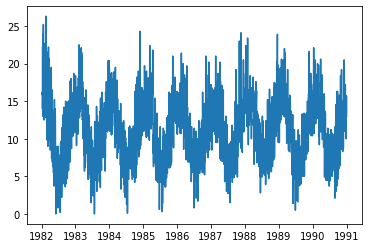

In [11]:
plt.plot(df["Date"], df["Temp"])

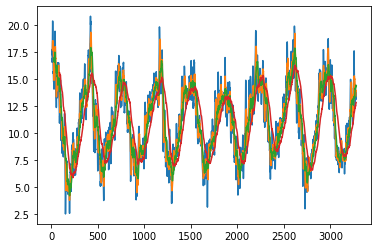

In [12]:
plt.plot(df['Temp'].rolling(7).mean())
plt.plot(df['Temp'].rolling(14).mean())
plt.plot(df['Temp'].rolling(30).mean())
plt.plot(df['Temp'].rolling(90).mean())

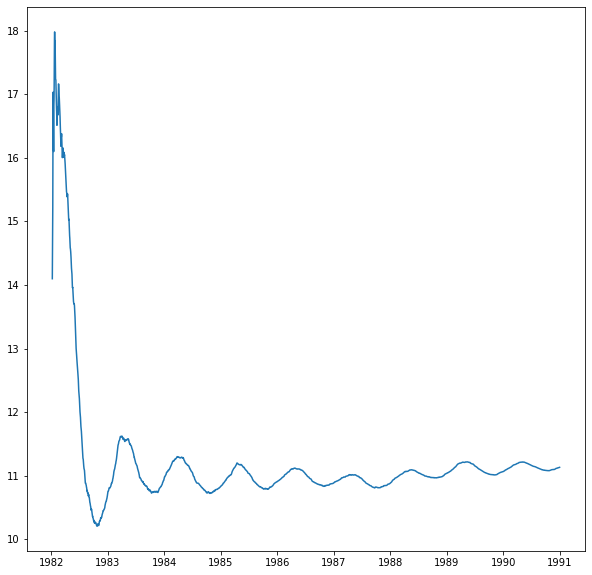

In [13]:
plt.figure(figsize=(10,10)) 
plt.plot(df['Date'], df["mov_avg"])

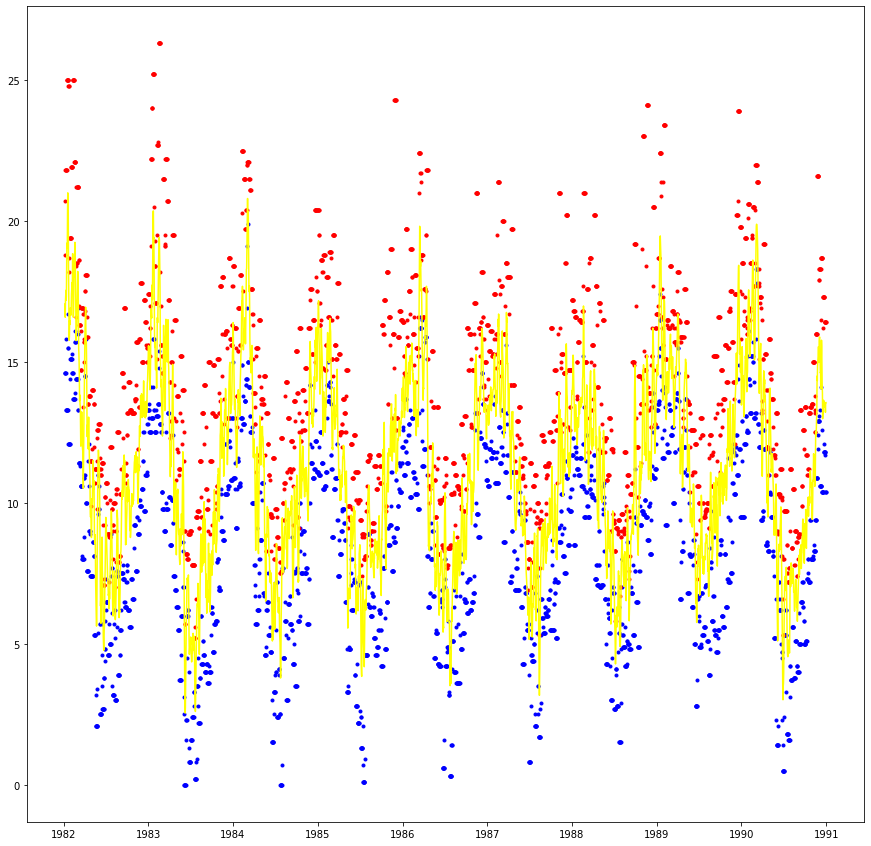

In [14]:
plt.figure(figsize=(15,15)) 
plt.plot(df['Date'], df["rolling_mean"], color='yellow')
plt.scatter(df['Date'], df["rolling_min"], marker='.', color='blue')
plt.scatter(df['Date'], df["rolling_max"], marker='.', color='red')

### Exponential Moving Average:

Text(0, 0.5, 'Temperature')

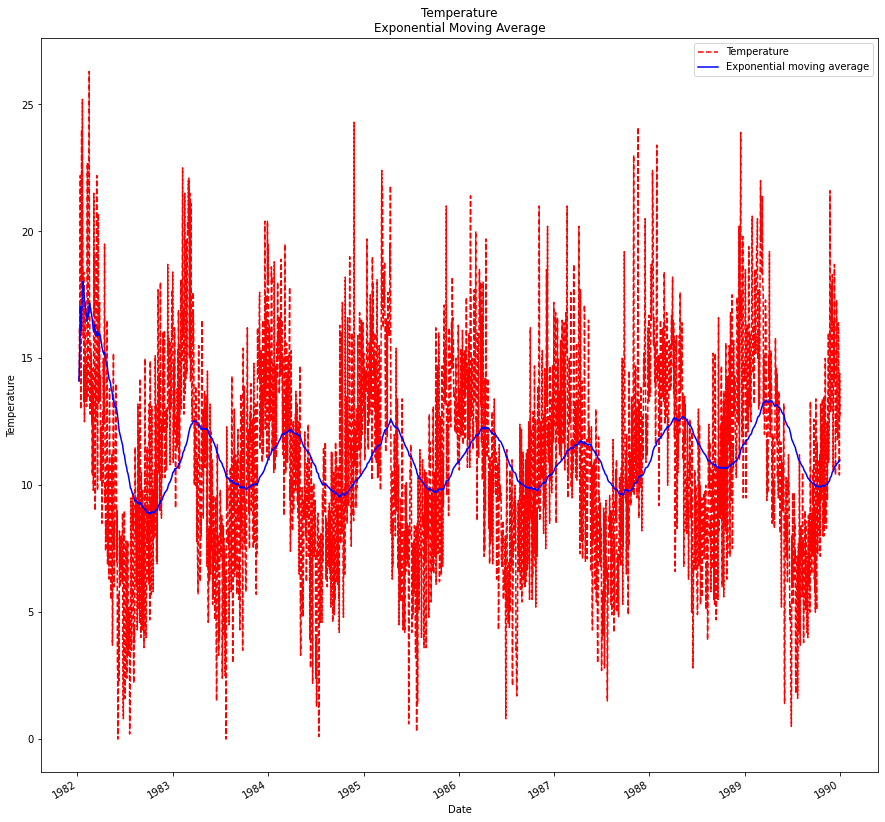

In [15]:
input_data = df[["Date", "Temp"]]

subset = input_data[input_data["Date"] <= "1989-12-31"]
subset.set_index('Date', inplace=True)
subset['Temp'].ewm(span = 360).mean()


plt.figure(figsize=(15,15))
subset['Temp'].plot(style = 'r--', label = 'Temperature')
subset['Temp'].ewm(span = 360).mean().plot(style = 'b', label = 'Exponential moving average')

plt.legend()
plt.title("Temperature\nExponential Moving Average")
plt.xlabel('Date')
plt.ylabel('Temperature')

### Check for outliers:

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d2fe92910>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d2fe9a1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d2fe92550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d2fe9aa90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d2fe9aed0>],
 'means': []}

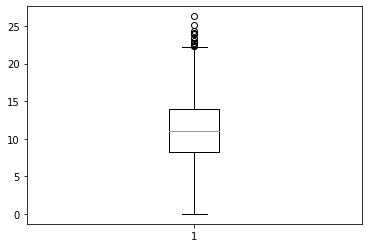

In [16]:
plt.boxplot(df["Temp"])

In [17]:
highest_temps = df["Temp"].sort_values(ascending=False).head(10)
highest_temps

39      26.3
13      25.2
1054    24.3
2141    24.1
10      24.0
2534    23.9
2213    23.4
2124    23.0
38      22.8
32      22.7
Name: Temp, dtype: float64

In [18]:
lowest_temps = df["Temp"].sort_values(ascending=True).head(10)
lowest_temps

149     0.0
563     0.0
919     0.1
194     0.2
1293    0.3
1292    0.3
2727    0.5
1262    0.6
918     0.7
564     0.7
Name: Temp, dtype: float64

### Split dataframes for modeling:

In [19]:
# split datasets

X_train = df.loc[(df['Year'] <= 1989)]
X_test = df.loc[(df['Year'] == 1990)]
Y_train = X_train["Temp"]
Y_test = X_test["Temp"]
X_train = X_train.drop(["Date", "Temp"], axis=1)
X_test = X_test.drop(["Date", "Temp"], axis=1)

#### Linear Regression:

In [20]:
regr = LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

In [21]:
y_pred_regr = regr.predict(X_test)
y_pred_regr

array([14.62522225, 14.72168578, 15.46281983, 15.71907733, 15.60279082,
       15.05476286, 14.65916588, 14.60527065, 14.82750676, 14.83323023,
       14.68808626, 14.52499902, 14.90416499, 14.89514853, 14.90572605,
       15.3062173 , 15.64258576, 15.70760885, 15.48203815, 15.44487715,
       15.53456767, 15.5891085 , 15.14496971, 14.96836441, 14.81403721,
       14.93336541, 15.12586517, 15.54680089, 15.78199702, 16.0800366 ,
       16.37803258, 16.39367841, 16.1449569 , 16.03187042, 15.96758764,
       15.59200984, 15.31435424, 15.17852485, 15.41476265, 15.69900645,
       15.73040444, 15.58428182, 15.55422022, 15.82552646, 15.86728531,
       16.08524508, 16.18743782, 16.29327336, 16.42860315, 16.61104234,
       16.39010084, 16.08477199, 15.96445595, 15.73617216, 15.51149464,
       15.212653  , 15.46050671, 15.34779435, 15.27260582, 14.31789354,
       14.77120154, 14.99044845, 15.0119287 , 15.29595289, 15.69358442,
       15.65247635, 15.54630958, 15.53321792, 15.66910953, 15.53

In [22]:
mean_squared_error(y_pred_regr, Y_test, squared=False)

2.6736368332493545

In [23]:
regr.score(X_test, Y_test)

0.5193137911559416

#### Random Forest Regressor:

In [24]:
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [25]:
y_pred_clf = clf.predict(X_test)
y_pred_clf

array([15.647, 14.952, 15.202, 16.057, 16.446, 16.534, 16.641, 16.628,
       15.852, 16.144, 16.164, 16.085, 16.087, 16.366, 16.164, 16.03 ,
       16.388, 16.263, 16.766, 15.946, 15.563, 15.7  , 15.651, 16.096,
       15.894, 16.024, 16.364, 15.829, 15.907, 15.937, 15.52 , 15.77 ,
       16.556, 15.861, 15.759, 15.873, 16.819, 16.81 , 16.492, 17.024,
       16.873, 16.502, 16.77 , 15.938, 15.709, 15.872, 15.817, 16.032,
       16.06 , 16.142, 15.559, 15.116, 15.253, 15.78 , 15.882, 15.939,
       16.332, 14.781, 16.511, 18.483, 18.216, 17.902, 18.602, 16.594,
       15.51 , 15.638, 15.433, 15.676, 15.725, 15.617, 15.179, 16.59 ,
       16.558, 16.208, 16.716, 17.404, 16.587, 16.735, 15.973, 16.349,
       16.72 , 15.794, 14.478, 13.652, 13.121, 13.173, 13.075, 13.562,
       14.192, 14.372, 15.031, 13.624, 13.718, 13.891, 13.774, 13.035,
       13.137, 12.157, 11.849, 12.267, 12.077, 13.288, 12.701, 12.924,
       12.697, 11.575, 10.49 ,  9.645, 10.255, 11.917, 12.117, 12.267,
      

In [26]:
clf.score(X_test, Y_test)

0.4934425210563016

In [27]:
mean_squared_error(y_pred_clf, Y_test, squared=False)

2.7446435519748746

### ARIMA - Autoregressive Integrated Moving Average

In [28]:
yani = df.groupby('Date')['Temp'].sum().reset_index()

In [29]:
yani = yani.set_index('Date')
yani.index

DatetimeIndex(['1982-01-07', '1982-01-08', '1982-01-09', '1982-01-10',
               '1982-01-11', '1982-01-12', '1982-01-13', '1982-01-14',
               '1982-01-15', '1982-01-16',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3279, freq=None)

In [30]:
y = yani['Temp'].resample('MS').mean()

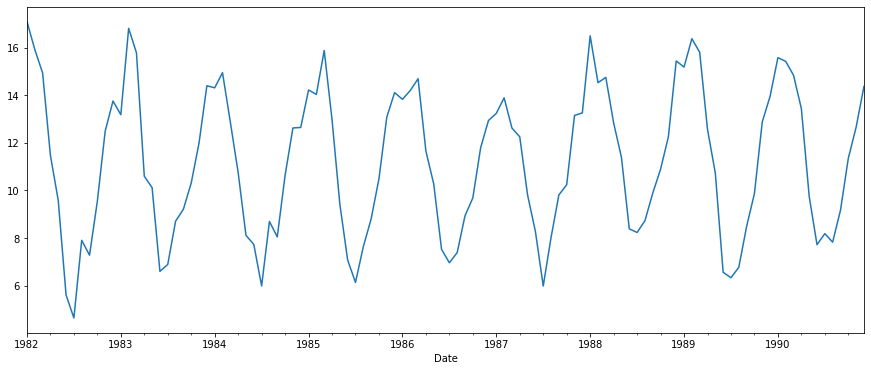

In [31]:
y.plot(figsize=(15, 6))
plt.show()

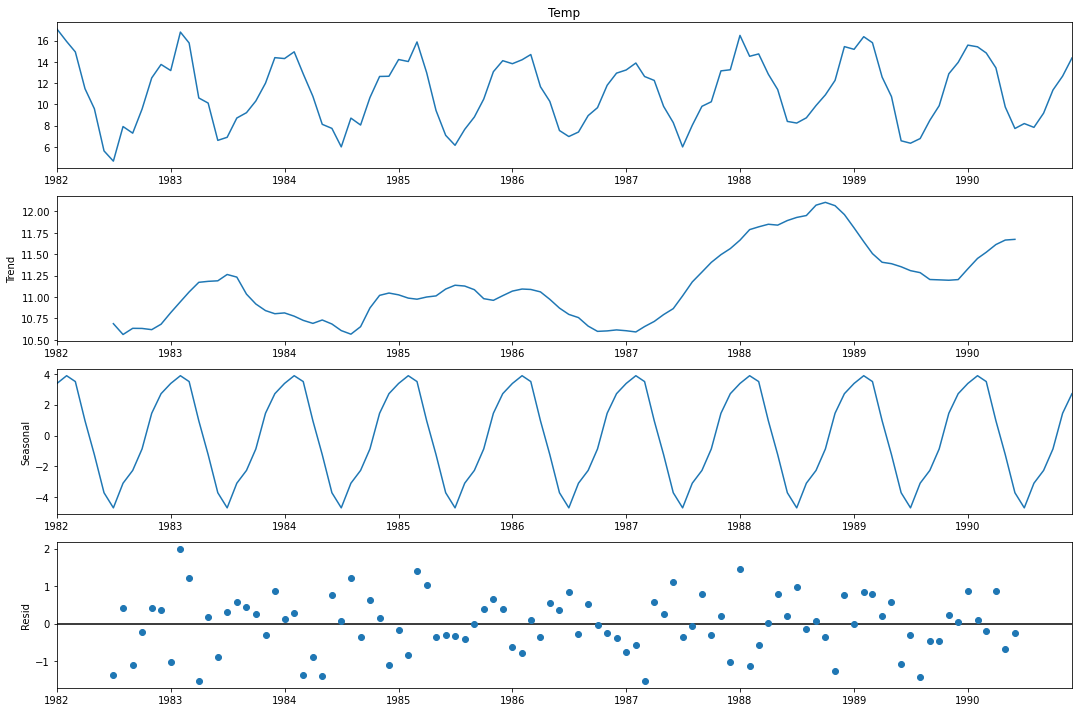

In [32]:
rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [33]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [34]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:828.738942831
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:648.1127996188254
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:311.13353260653605
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:242.42893601560417
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:325.0899857198783
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:276.4063988883812
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:252.5851509947816
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:245.20503828412197
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:695.9213373053308
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:549.7912342949353
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:307.8514121738016
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:237.44425422735938
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:325.26352558769304
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:272.84464259216446
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:252.12986169870595
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:239.77726438098534
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:443.32245412726627
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:361.98414830598415
ARIM

In [44]:
# choose best ARIMA (Lowest AIC)

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1710      0.119      1.439      0.150      -0.062       0.404
ma.L1         -1.0000    152.842     -0.007      0.995    -300.565     298.565
ma.S.L12      -0.7488      0.142     -5.289      0.000      -1.026      -0.471
sigma2         0.8049    123.022      0.007      0.995    -240.314     241.924


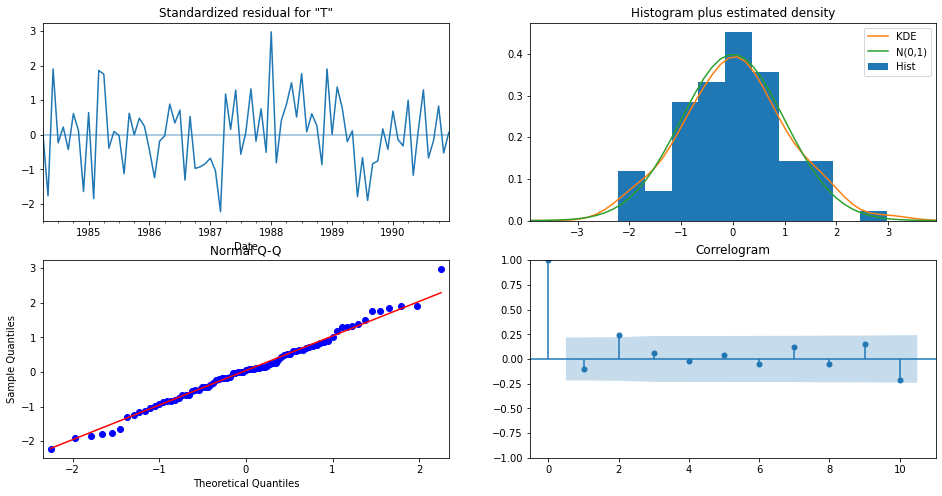

In [36]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

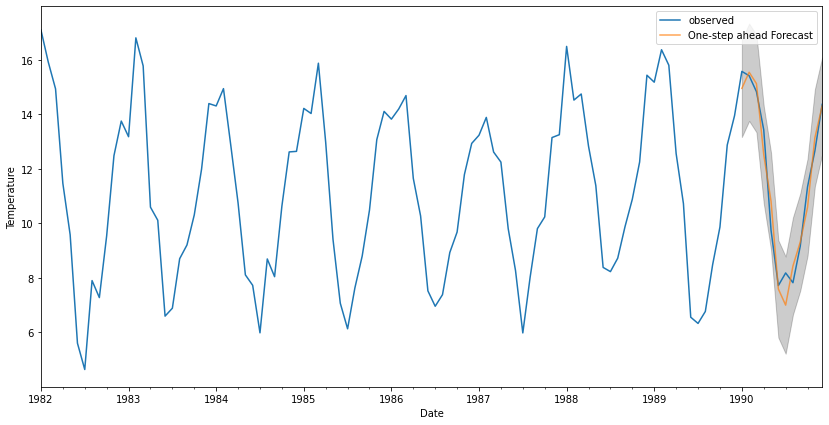

In [37]:
pred = results.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['1982':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [46]:
pred_ci

,lower Temp,upper Temp
Date,,
1990-01-01,13.168414,16.739939
1990-02-01,13.761522,17.330941
1990-03-01,13.344314,16.912610
1990-04-01,10.739916,14.307144
1990-05-01,9.029919,12.596130
1990-06-01,5.814004,9.379244
1990-07-01,5.221189,8.785503
1990-08-01,6.655510,10.218939
1990-09-01,7.536444,11.099026


In [41]:
y_forecasted = pred.predicted_mean
y_forecasted

Date
1990-01-01    14.954176
1990-02-01    15.546231
1990-03-01    15.128462
1990-04-01    12.523530
1990-05-01    10.813025
1990-06-01     7.596624
1990-07-01     7.003346
1990-08-01     8.437224
1990-09-01     9.317735
1990-10-01    10.591108
1990-11-01    13.136200
1990-12-01    14.308458
Freq: MS, Name: predicted_mean, dtype: float64

In [42]:
y_truth = y['1990-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.42


In [43]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.65


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32db7cc2-13d9-4e2f-9e0f-6b30332ec4dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>